<a id="A"></a>
<div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#28a745; overflow:hidden"><b> Brain Stroke Classification with Transfer Learning </b></div>

![brain](https://i.vimeocdn.com/video/663892561-e13235b351d37090718f37942a5c40903728212d86e47584f2a7a812764d5667-d?mw=1920&mh=1080&q=70)

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#28a745; overflow:hidden"><b> Introduction </b></div>

<h2>Project Introduction 📝</h2>
<div style="padding: 20px; border-color: #c77220; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #28a745;">
    <ul style="font-size: 18px; font-family: 'Arial'; line-height: 1.5em;">
        In recent years, the prevalence of brain strokes has increased significantly, posing a serious public health challenge. Early detection and diagnosis of strokes are critical for improving patient outcomes and reducing the risk of long-term disabilities or fatalities. This project leverages deep learning techniques to classify brain strokes using medical imaging data, specifically focusing on images derived from MRI scans.

The main objective of this project is to develop a robust classification model that can accurately differentiate between stroke and non-stroke cases. By utilizing advanced convolutional neural networks (CNNs) such as DenseNet121, ResNet50, and Xception, the project aims to harness the power of transfer learning to achieve high accuracy with limited training data.
    </ul>
</div>

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#28a745; overflow:hidden"><b> Import Libraries 📚 </b></div>

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.xception import Xception
from sklearn.metrics import classification_report
from tensorflow import keras
from deepstack.base import KerasMember
import requests
from io import BytesIO

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#28a745; overflow:hidden"><b> Load data ✅ </b></div>

In [2]:
trainpath='image/train'
testpath='image/Test'
validpath='image/Validation'

In [3]:
Img_size=(228,228)
batch_size=34

In [4]:
train_ds=tf.keras.utils.image_dataset_from_directory(
trainpath,seed=123,image_size=Img_size,batch_size=batch_size)

Found 1843 files belonging to 2 classes.


In [5]:
valid_ds=tf.keras.utils.image_dataset_from_directory(
validpath,seed=123,image_size=Img_size,batch_size=batch_size)

Found 235 files belonging to 2 classes.


In [6]:
test_ds=tf.keras.utils.image_dataset_from_directory(
testpath,shuffle=False,image_size=Img_size,batch_size=batch_size)

Found 437 files belonging to 2 classes.


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#28a745; overflow:hidden"><b> Data Visualization 📊 </b></div>

In [7]:
class_names=train_ds.class_names
class_names

['Normal', 'Stroke']

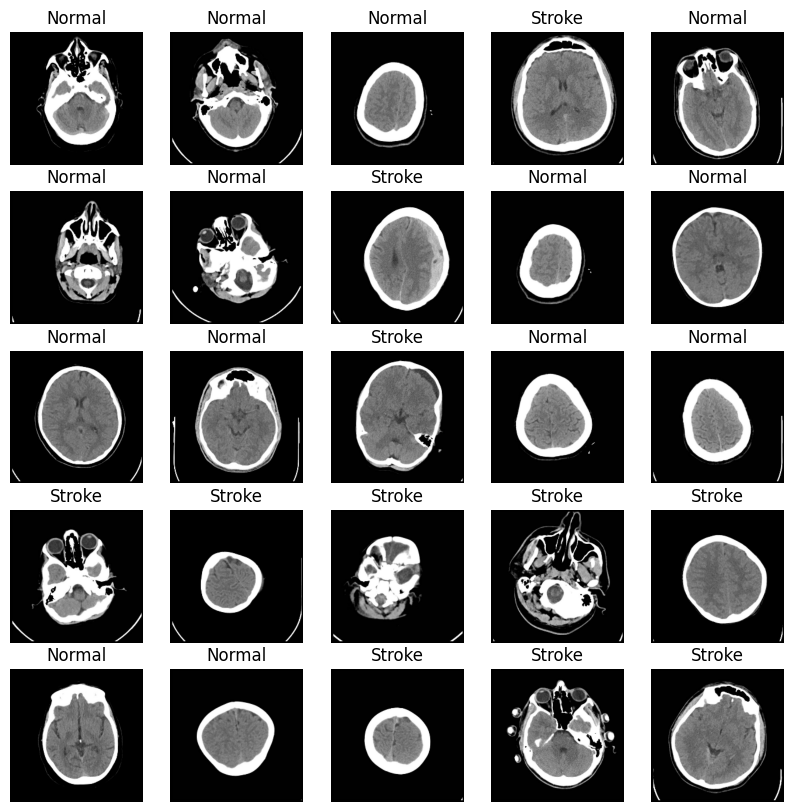

In [8]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

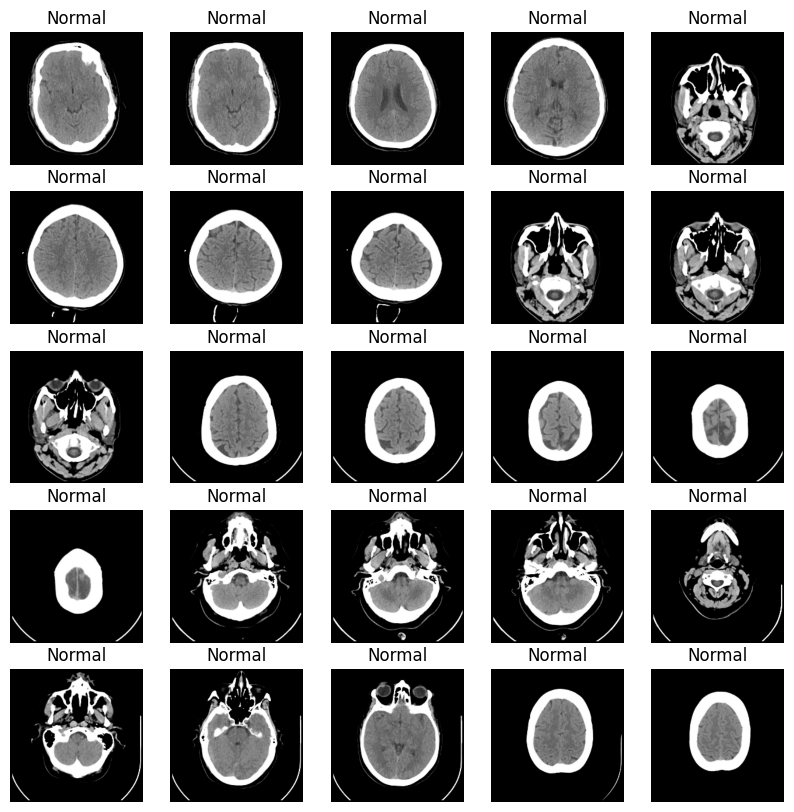

In [9]:
plt.figure(figsize=(10,10))
for images,labels in test_ds.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

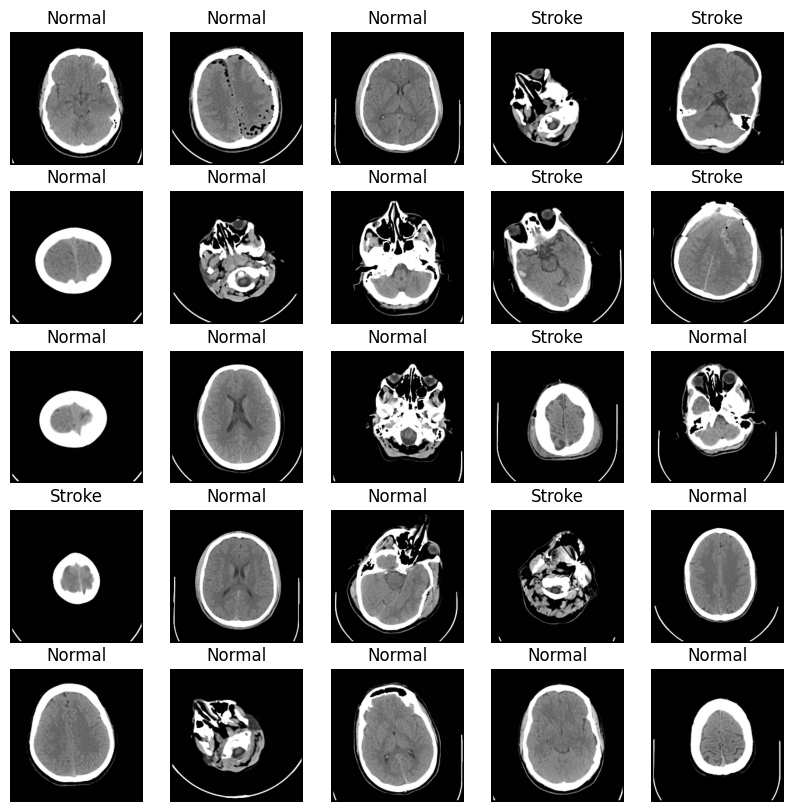

In [10]:
plt.figure(figsize=(10,10))
for images,labels in valid_ds.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [11]:
class_counts = {}
for class_name in os.listdir(trainpath):
    class_dir = os.path.join(trainpath, class_name)  
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))  
        class_counts[class_name] = num_images  
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

Normal: 1087 images
Stroke: 756 images


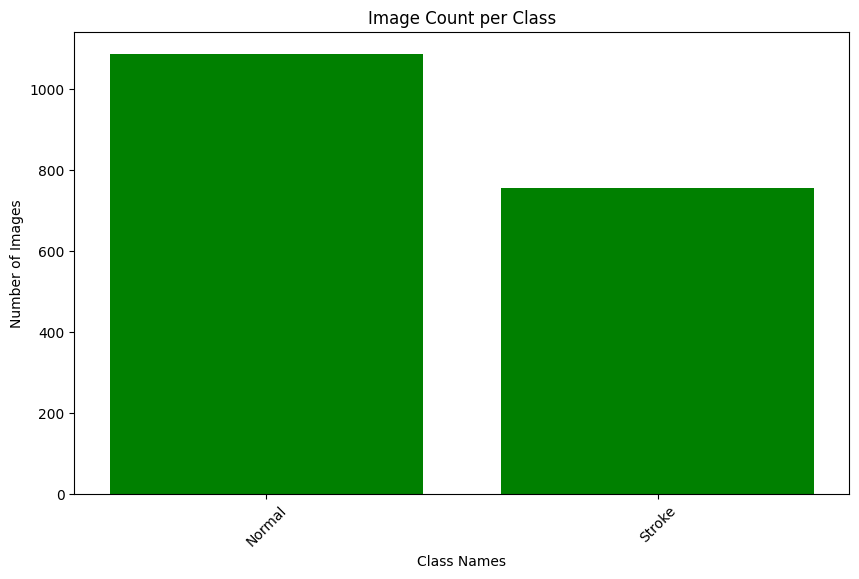

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='green')
plt.title('Image Count per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45) 
plt.show()

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#28a745; overflow:hidden"><b> Build Model 🎯 </b></div>

In [13]:
anne = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=2, min_lr=0.0000001,min_delta=0.00001,mode='auto')
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
callbacks1 =[anne,earlystop]

## DenseNet121 Model

In [14]:
base_model=DenseNet121(input_shape=(228,228,3),include_top=False,weights='imagenet')
for layer in base_model.layers:
    layer.trainable=True
x=base_model.output
x=Flatten()(x)
pred=Dense(1,activation='sigmoid')(x)
model1 = Model(inputs=base_model.input, outputs=pred)

In [15]:
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 228, 228,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 234, 234,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 114, 114,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 114, 114,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 114, 114,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 116, 116,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 57, 57,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 57, 57,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 57, 57,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 57, 57,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 57, 57,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 57, 57,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 57, 57,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 57, 57,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 57, 57,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 57, 57,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 57, 57,    │     12,288 │ conv2_block2_0_r

 Total params: 7,087,681 (27.04 MB)

 Trainable params: 7,004,033 (26.72 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [16]:
model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

In [17]:
history1 = model1.fit( train_ds,epochs=10,
                    validation_data= valid_ds,
                    callbacks=[callbacks1]) 

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2763s 47s/step - accuracy: 0.5501 - loss: 2.1508 - precision: 0.4659 - recall: 0.4578 - val_accuracy: 0.6638 - val_loss: 1272.1898 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2652s 48s/step - accuracy: 0.6283 - loss: 1.1734 - precision: 0.5504 - recall: 0.5339 - val_accuracy: 0.6255 - val_loss: 18590.6797 - val_precision: 0.3864 - val_recall: 0.2179 - learning_rate: 0.0010
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2524s 46s/step - accuracy: 0.7111 - loss: 0.9566 - precision: 0.6375 - recall: 0.6875 - val_accuracy: 0.6723 - val_loss: 2.5598 - val_precision: 1.0000 - val_recall: 0.0128 - learning_rate: 0.0010
Epoch 4/10
29/55 ━━━━━━━━━━━━━━━━━━━━ 20:26 47s/step - accuracy: 0.7487 - loss: 0.8290 - precision: 0.7054 - recall: 0.6882

In [18]:
loss, accuracy,pre,rec = model1.evaluate(valid_ds)
print(f'valid accuracy: {accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7884 - loss: 0.4850 - precision: 0.6437 - recall: 0.8751
valid accuracy: 78.72%


## RESNet 50 Model

In [19]:
base_model=ResNet50(input_shape=(228,228,3),include_top=False,weights='imagenet')
for layer in base_model.layers:
    layer.trainable=True
x=base_model.output
x=Flatten()(x)
pred=Dense(1,activation='sigmoid')(x)
model2 = Model(inputs=base_model.input, outputs=pred)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 35s 0us/step


In [20]:
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 228, 228,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 234, 234,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 114, 114,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 114, 114,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 114, 114,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 116, 116,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 57, 57,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 57, 57,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 57, 57,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 57, 57,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 57, 57,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 57, 57,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 57, 57,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 57, 57,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 57, 57,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 57, 57,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 57, 57,    │      1,024 │ conv2_block1_3_c

 Total params: 23,718,785 (90.48 MB)

 Trainable params: 23,665,665 (90.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [21]:
anne = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=2, min_lr=0.0000001,min_delta=0.00001,mode='auto')
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
callbacks2 =[anne,earlystop]

In [23]:
model2.compile(optimizer='adam',loss ='binary_crossentropy',metrics=['accuracy'])
history2=model2.fit(train_ds,
                    validation_data=valid_ds,epochs=10,callbacks=[callbacks2])

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 809s 13s/step - accuracy: 0.8213 - loss: 0.7264 - val_accuracy: 0.6723 - val_loss: 117909.3438 - learning_rate: 0.0010
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 692s 13s/step - accuracy: 0.9383 - loss: 0.2117 - val_accuracy: 0.6681 - val_loss: 111925.5312 - learning_rate: 0.0010
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 792s 14s/step - accuracy: 0.9211 - loss: 0.3628 - val_accuracy: 0.6511 - val_loss: 10816.4980 - learning_rate: 0.0010
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 814s 15s/step - accuracy: 0.9259 - loss: 0.3304 - val_accuracy: 0.5362 - val_loss: 18468.8301 - learning_rate: 0.0010
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 755s 14s/step - accuracy: 0.9452 - loss: 0.2113 - val_accuracy: 0.7404 - val_loss: 30.3181 - learning_rate: 0.0010
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 765s 14s/step - accuracy: 0.9608 - loss: 0.1441 - val_accuracy: 0.9191 - val_loss: 1.9163 - learning_rate: 0.0010
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 777s 14s/step - accuracy: 0.988

In [1]:
loss2,accuracy2=model2.evaluate(valid_ds)
print(f'Valid accuracy of ResNet50 : {accuracy2}')

NameError: name 'model2' is not defined

In [27]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model2.predict(test_ds, verbose=1).round()
y_pred = y_pred.flatten()
target_names=['Normal', 'Stroke']
report=classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step
              precision    recall  f1-score   support

      Normal     0.9900    0.9642    0.9769       307
      Stroke     0.9203    0.9769    0.9478       130

    accuracy                         0.9680       437
   macro avg     0.9551    0.9705    0.9623       437
weighted avg     0.9692    0.9680    0.9682       437



## Xception Model

In [28]:
base_model=Xception(input_shape=(228,228,3),include_top=False,weights='imagenet')
for layer in base_model.layers:
    layer.trainable=True
x=base_model.output
x=Flatten()(x)
pred=Dense(1,activation='sigmoid')(x)
model3 = Model(inputs=base_model.input, outputs=pred)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [29]:
model3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 228, 228,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 113, 113,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 113, 113,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 113, 113,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 111, 111,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 111, 111,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 111, 111,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 111, 111,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 111, 111,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 111, 111,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 111, 111,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 111, 111,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 56, 56,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 56, 56,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 56, 56,    │          0 │ add[0][0]       

 Total params: 20,961,833 (79.96 MB)

 Trainable params: 20,907,305 (79.76 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [30]:
anne = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=2, min_lr=0.0000001,min_delta=0.00001,mode='auto')
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
callbacks3 =[anne,earlystop]

In [34]:
model3.compile(optimizer='adam',loss ='binary_crossentropy',metrics=['accuracy'])
history3=model3.fit(train_ds,
                    validation_data=valid_ds,epochs=10,callbacks=[callbacks3])

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2642s 47s/step - accuracy: 0.6187 - loss: 0.5531 - val_accuracy: 0.6681 - val_loss: 52.4451 - learning_rate: 0.0010
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2677s 49s/step - accuracy: 0.8084 - loss: 0.4417 - val_accuracy: 0.6681 - val_loss: 35.2265 - learning_rate: 0.0010
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2660s 48s/step - accuracy: 0.8234 - loss: 0.3707 - val_accuracy: 0.6851 - val_loss: 20.6296 - learning_rate: 0.0010
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2713s 50s/step - accuracy: 0.9059 - loss: 0.2484 - val_accuracy: 0.8596 - val_loss: 1.9895 - learning_rate: 0.0010
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2774s 50s/step - accuracy: 0.9221 - loss: 0.2274 - val_accuracy: 0.6043 - val_loss: 6.3966 - learning_rate: 0.0010
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2696s 49s/step - accuracy: 0.9513 - loss: 0.1076 - val_accuracy: 0.8553 - val_loss: 0.9032 - learning_rate: 0.0010
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2303s 42s/step - accuracy: 0.9729 - loss:

In [53]:
loss3,acc3=model3.evaluate(valid_ds)
print(f'accuracy of Xception : {acc3}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9954 - loss: 0.0108
accuracy of Xception : 0.9957447052001953


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#28a745; overflow:hidden"><b> Evaluate Models ✅ </b></div>

## DenseNet 

In [58]:
loss,acc1,pre,recall=model1.evaluate(test_ds)
print(f'DenseNet accuracy: {acc1* 100:.2f}%')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9543 - loss: 0.2140 - precision: 0.3074 - recall: 0.3549
DenseNet accuracy: 96.80%


In [54]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model1.predict(test_ds, verbose=1).round()
y_pred = y_pred.flatten()
target_names=['Normal', 'Stroke']
report=classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
              precision    recall  f1-score   support

      Normal     0.9933    0.9609    0.9768       307
      Stroke     0.9143    0.9846    0.9481       130

    accuracy                         0.9680       437
   macro avg     0.9538    0.9728    0.9625       437
weighted avg     0.9698    0.9680    0.9683       437



## ResNet50

In [59]:
loss,acc2=model2.evaluate(test_ds)
print(f'ResNet accuracy: {acc2 * 100:.2f}%')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9885 - loss: 0.0527
ResNet accuracy: 98.40%


In [60]:
y_pred = model2.predict(test_ds, verbose=1).round()
y_pred = y_pred.flatten()
target_names=['Normal', 'Stroke']
report=classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
              precision    recall  f1-score   support

      Normal     0.9934    0.9837    0.9885       307
      Stroke     0.9624    0.9846    0.9734       130

    accuracy                         0.9840       437
   macro avg     0.9779    0.9842    0.9810       437
weighted avg     0.9842    0.9840    0.9840       437



## Xception

In [61]:
loss,acc3=model3.evaluate(test_ds)
print(f'Xception accuracy: {acc3 * 100:.2f}%')

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 843ms/step - accuracy: 0.9872 - loss: 0.0396
Xception accuracy: 98.63%


In [62]:
y_pred = model3.predict(test_ds, verbose=1).round()
y_pred = y_pred.flatten()
target_names=['Normal', 'Stroke']
report=classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step
              precision    recall  f1-score   support

      Normal     0.9967    0.9837    0.9902       307
      Stroke     0.9627    0.9923    0.9773       130

    accuracy                         0.9863       437
   macro avg     0.9797    0.9880    0.9837       437
weighted avg     0.9866    0.9863    0.9863       437



Xception give the best accuracy

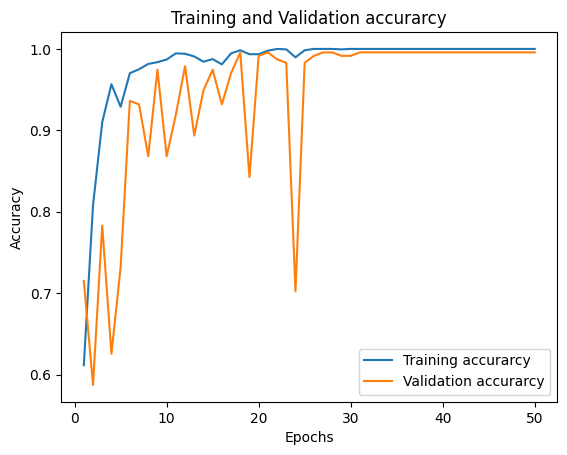

In [77]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

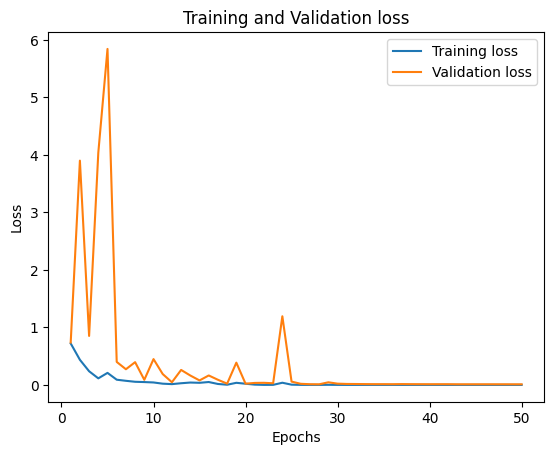

In [78]:
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#28a745; overflow:hidden"><b> Save Models ✅ </b></div>

In [63]:
model1.save('DenseNet121.keras')
model3.save("Xception.keras")
model2.save("ResNet50.keras")

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#28a745; overflow:hidden"><b> Make Prediction 🎯 </b></div>

In [89]:
def predict_img(url, model):
    response = requests.get(url)
    img = image.load_img(BytesIO(response.content), target_size=(228, 228))
    img_array = image.img_to_array(img)
    img_pro = np.expand_dims(img_array, axis=0)
    img_pro /= 255  

    img_pred = model3.predict(img_pro)
    index = np.argmax(img_pred)

    plt.title("Prediction - {}".format(str(class_names[index]).title()), size=18, color='red')
    plt.imshow(img_array)
    plt.axis('off')  
    plt.show()

In [2]:
predict_img('https://img.medscapestatic.com/pi/meds/ckb/36/15136tn.jpg',model3)

NameError: name 'predict_img' is not defined